In [14]:
## IMPORTS
import time, os, requests, threading
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
from google.cloud import storage
import concurrent.futures
import urllib.request
from io import StringIO
import seaborn as sns


In [15]:
#!pip install seaborn

In [3]:
# FUNCTIONS
def create_airqual_dict(city, city_name, state):
    """Return dictionary of airqual results by City."""
    city_live_dict = {}
    local_dt = city['data']['time']['s']
    try: local_date = datetime.strptime(local_dt, '%Y-%m-%d %H:%M:%S').strftime('%Y-%m-%d')
    except: local_date = None
    try: local_time = datetime.strptime(local_dt, '%Y-%m-%d %H:%M:%S').strftime('%H:%M')
    except: local_time = None
    city_live_dict['local_date_airqual'] = local_date
    city_live_dict['local_time_airqual'] = local_time
    
    UTC_dt = city['data']['time']['s']
    UTC_timezone = city['data']['time']['tz']
    UTC_timezone = int(datetime.strptime(UTC_timezone, '-%H:%M').strftime('%H'))
    UTC_dt_adjusted = datetime.strptime(UTC_dt, '%Y-%m-%d %H:%M:%S') + timedelta(hours=UTC_timezone)
    try: UTC_date = datetime.strptime(str(UTC_dt_adjusted), '%Y-%m-%d %H:%M:%S').strftime('%Y-%m-%d')
    except: UTC_date = None
    try: UTC_time = datetime.strptime(str(UTC_dt_adjusted), '%Y-%m-%d %H:%M:%S').strftime('%H:%M')
    except: UTC_time = None
    city_live_dict['UTC_date'] = UTC_date
    city_live_dict['UTC_time'] = UTC_time
    
    
    try: city_live_dict['city'] = city_name #city['data']['city']['name']
    except: city_live_dict['city']= None
    try: city_live_dict['state'] = state
    except: city_live_dict['state']= None
    try: city_live_dict['full_time'] = city['data']['time']['s']
    except: city_live_dict['full_time'] = None
    try: city_live_dict['time zone'] = city['data']['time']['tz']
    except: city_live_dict['time zone'] = None
    try: city_live_dict['second'] = city['data']['time']['v']
    except: city_live_dict['second'] = None
    try: city_live_dict['lat_airqual'] = city['data']['city']['geo'][0]
    except: city_live_dict['lat_airqual'] = None
    try: city_live_dict['long_airqual'] = city['data']['city']['geo'][1]
    except: city_live_dict['long_airqual'] = None
    try: city_live_dict['aqi'] = city['data']['aqi']
    except: city_live_dict['aqi'] = None
    try: city_live_dict['pm2.5'] = city['data']['iaqi']['pm25']['v']
    except: city_live_dict['pm2.5'] = None
    try: city_live_dict['co'] = city['data']['iaqi']['co']['v']
    except: city_live_dict['co'] = None
    try: city_live_dict['no2'] = city['data']['iaqi']['no2']['v']
    except: city_live_dict['no2'] = None
    try: city_live_dict['o3'] = city['data']['iaqi']['o3']['v']
    except: city_live_dict['o3'] = None
    try: city_live_dict['humidity_airqual'] = city['data']['iaqi']['h']['v']
    except: city_live_dict['humidity_airqual'] = None
    try: city_live_dict['pressure_airqual'] = city['data']['iaqi']['p']['v']
    except: city_live_dict['pressure_airqual'] = None
    
    return city_live_dict


def create_weather_dict(data, state):
    data_dict = {}
    
    local_dt = data['dt'] + data['timezone']
    try: local_date = datetime.utcfromtimestamp(local_dt).strftime('%Y-%m-%d')
    except: local_date = None
    try: local_time = datetime.utcfromtimestamp(local_dt).strftime('%H:00')
    except: local_time = None
    data_dict['local_date_weather'] = local_date
    data_dict['local_time_weather'] = local_time
    UTC_dt = data['dt']
    try: UTC_date = datetime.utcfromtimestamp(UTC_dt).strftime('%Y-%m-%d')
    except: UTC_date = None
    try: UTC_time = datetime.utcfromtimestamp(UTC_dt).strftime('%H:00')
    except: UTC_time = None
    data_dict['UTC_date'] = UTC_date
    data_dict['UTC_time'] = UTC_time

    # (K − 273.15) × 9/5 + 32 #Kelvin to F
    try: data_dict['city'] = data['name']
    except: data_dict['city'] = None
    try: data_dict['state'] = state
    except: data_dict['state'] = None
    try: data_dict['long_weather'] = data['coord']['lon']
    except: data_dict['long_weather'] = None
    try: data_dict['lat_weather'] = data['coord']['lat']
    except: data_dict['lat_weather'] = None
    try: data_dict['weather_id'] = data['weather'][0]['id']
    except: data_dict['weather_id'] = None
    try: data_dict['weather_clouds'] = data['weather']['clouds']
    except: data_dict['weather_clouds'] = None
    try: data_dict['weather_main'] = data['weather'][0]['main']
    except: data_dict['weather_main'] = None
    try: data_dict['weather_description'] = data['weather'][0]['description']
    except: data_dict['weather_description'] = None
    try: data_dict['temp'] = round((data['main']['temp'] - 273.15) * 9/5 + 32, 2) #Kelvin to F
    except: data_dict['temp'] = None
    try: data_dict['feels_like'] = round((data['main']['feels_like'] - 273.15) * (9/5) + 32, 2) #Kelvin to F
    except: data_dict['feels_like'] = None
    try: data_dict['temp_min'] = round((data['main']['temp_min'] - 273.15) * (9/5) + 32, 2) #Kelvin to F
    except: data_dict['temp_min'] = None
    try: data_dict['temp_max'] = round((data['main']['temp_max'] - 273.15) * (9/5) + 32, 2) #Kelvin to F
    except: data_dict['temp_max'] = None
    try: data_dict['pressure_weather'] = data['main']['pressure']
    except: data_dict['pressure_weather'] = None
    try: data_dict['humidity_weather'] = data['main']['humidity']
    except: data_dict['humidity_weather'] = None
    try: data_dict['visibility'] = data['visibility']
    except: data_dict['visibility'] = None
    try: data_dict['wind_speed'] = data['wind']['speed']
    except: data_dict['wind_speed'] = None
    try: data_dict['wind_deg'] = data['wind']['deg']
    except: data_dict['wind_deg'] = None
    try: data_dict['wind_gust'] = data['wind']['gust']
    except: data_dict['wind_gust'] = None
    
    sunrise_time = data['sys']['sunrise'] + data['timezone']
    sunset_time = data['sys']['sunset'] + data['timezone']
    try: data_dict['sunrise'] = datetime.utcfromtimestamp(sunrise_time).strftime('%H:%M:%S')
    except: data_dict['sunrise'] = None
    try: data_dict['sunset'] = datetime.utcfromtimestamp(sunset_time).strftime('%H:%M:%S')
    except: data_dict['sunset'] = None
    
    return data_dict


In [4]:
 ## LOAD THE AIRQUAL & WEATHER DATA PER STATE

def getList(dict):
    return dict.keys()

Capitals_dict = {"Alabama": {"City": "Montgomery", "Weather_Code": 4076784, "Airqual_Code": 7379}, "Alaska": {"City": "Juneau", "Weather_Code": 5554072, "Airqual_Code": 7610}, "Arizona": {"City": "Phoenix", "Weather_Code": 5308655, "Airqual_Code": 5944}, "Arkansas": {"City": "Little Rock", "Weather_Code": 4119403, "Airqual_Code": 7383}, "California": {"City": "Sacramento", "Weather_Code": 5389489, "Airqual_Code": 303}, "Colorado": {"City": "Denver", "Weather_Code": 5419384, "Airqual_Code": 6314}, "Connecticut": {"City": "Hartford", "Weather_Code": 4835797, "Airqual_Code": 7387}, "Delaware": {"City": "Dover", "Weather_Code": 4142290, "Airqual_Code": 7392}, "Florida": {"City": "Tallahassee", "Weather_Code": 4174715, "Airqual_Code": 6295}, "Georgia": {"City": "Atlanta", "Weather_Code": 4180439, "Airqual_Code": 13288}, "Hawaii": {"City": "Honolulu", "Weather_Code": 5856195, "Airqual_Code": 5273}, "Idaho": {"City": "Boise", "Weather_Code": 5586437, "Airqual_Code": 9615}, "Illinois": {"City": "Springfield", "Weather_Code": 4250542, "Airqual_Code": 9641}, "Indiana": {"City": "Indianapolis", "Weather_Code": 4259418, "Airqual_Code": 8699}, "Iowa": {"City": "Des Moines", "Weather_Code": 4853828, "Airqual_Code": 6924}, "Kansas": {"City": "Topeka", "Weather_Code": 4280539, "Airqual_Code": 9514}, "Kentucky": {"City": "Frankfort", "Weather_Code": 4292188, "Airqual_Code": 7330}, "Louisiana": {"City": "Baton Rouge", "Weather_Code": 4315588, "Airqual_Code": 12846}, "Maine": {"City": "Augusta", "Weather_Code": 4957003, "Airqual_Code": 7640}, "Maryland": {"City": "Annapolis", "Weather_Code": 4347242, "Airqual_Code": 7418}, "Massachusetts": {"City": "Boston", "Weather_Code": 4930956, "Airqual_Code": 5883}, "Michigan": {"City": "Lansing", "Weather_Code": 4998830, "Airqual_Code": 13070}, "Minnesota": {"City": "Saint Paul", "Weather_Code": 5045360, "Airqual_Code": 7348}, "Mississippi": {"City": "Jackson", "Weather_Code": 4431410, "Airqual_Code": 7432}, "Missouri": {"City": "Jefferson City", "Weather_Code": 4392388, "Airqual_Code": 7353}, "Montana": {"City": "Helena", "Weather_Code": 5656882, "Airqual_Code": 7523}, "Nebraska": {"City": "Lincoln", "Weather_Code": 5072006, "Airqual_Code": 7364}, "Nevada": {"City": "Carson City", "Weather_Code": 5501344, "Airqual_Code": 8350}, "New Hampshire": {"City": "Concord", "Weather_Code": 5084868, "Airqual_Code": 7449}, "New Jersey": {"City": "Trenton", "Weather_Code": 5105496, "Airqual_Code": 8530}, "New Mexico": {"City": "Santa Fe", "Weather_Code": 5490263, "Airqual_Code": 6281}, "New York": {"City": "Albany", "Weather_Code": 5106834, "Airqual_Code": 5100}, "North Carolina": {"City": "Raleigh", "Weather_Code": 4487042, "Airqual_Code": 7668}, "North Dakota": {"City": "Bismarck", "Weather_Code": 5688025, "Airqual_Code": 7445}, "Ohio": {"City": "Columbus", "Weather_Code": 4509177, "Airqual_Code": 7591}, "Oklahoma": {"City": "Oklahoma City", "Weather_Code": 4544349, "Airqual_Code": 10178}, "Oregon": {"City": "Salem", "Weather_Code": 5750162, "Airqual_Code": 89}, "Pennsylvania": {"City": "Harrisburg", "Weather_Code": 5192726, "Airqual_Code": 6423}, "Rhode Island": {"City": "Providence", "Weather_Code": 5224151, "Airqual_Code": 7478}, "South Carolina": {"City": "Columbia", "Weather_Code": 4575352, "Airqual_Code": 9515}, "South Dakota": {"City": "Pierre", "Weather_Code": 5767918, "Airqual_Code": 8359}, "Tennessee": {"City": "Nashville", "Weather_Code": 4644585, "Airqual_Code": 7496}, "Texas": {"City": "Austin", "Weather_Code": 4671654, "Airqual_Code": 224}, "Utah": {"City": "Salt Lake City", "Weather_Code": 5780993, "Airqual_Code": 12862}, "Vermont": {"City": "Montpelier", "Weather_Code": 5238685, "Airqual_Code": 7376}, "Virginia": {"City": "Richmond", "Weather_Code": 4781708, "Airqual_Code": 5357}, "Washington": {"City": "Olympia", "Weather_Code": 5805687, "Airqual_Code": 115}, "West Virginia": {"City": "Charleston", "Weather_Code": 4801859, "Airqual_Code": 9524}, "Wisconsin": {"City": "Madison", "Weather_Code": 5261457, "Airqual_Code": 10175}, "Wyoming": {"City": "Cheyenne", "Weather_Code": 5821086, "Airqual_Code": 9526}}

list_states = getList(Capitals_dict)

print(list_states)



dict_keys(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'])


In [6]:
results = pd.DataFrame()

for i in list_states:
    state_weather = Capitals_dict[i]['Weather_Code'] #Capitals_dict[i]['Weather_Code']
    state_airqual = Capitals_dict[i]['Airqual_Code'] #Capitals_dict[i]['Airqual_Code']
    weather_url = 'https://api.openweathermap.org/data/2.5/weather?id={}&appid=677381a374af2b031a7213a9531c9711'.format(state_weather)
    airqual_url = 'https://api.waqi.info/feed/@{}/?token=1fd4e786510e90210e6604b26f130f8dd2f53478'.format(state_airqual)

    weather_response = requests.get(weather_url)
    airqual_response = requests.get(airqual_url)

    weather_data = weather_response.json()
    airqual_data = airqual_response.json()

    ## CONVERT TO DICT
    weather_dict = {}
    weather_dict[0] = create_weather_dict(weather_data, i)
    weather_df = pd.DataFrame.from_dict(weather_dict, orient='index')

    airqual_dict = {}
    airqual_dict[1] = create_airqual_dict(airqual_data, Capitals_dict[i]['City'], i)
    airqual_df = pd.DataFrame.from_dict(airqual_dict, orient='index')

    # MERGE WEATHER AND AIRQUAL
    weather_airqual_df = pd.merge(airqual_df, weather_df, on=['city','state','UTC_date','UTC_time'], how='outer')

    # MERGE TO MASTER DF (results)
    results = pd.concat([results, weather_airqual_df])

results.head()

,local_date_airqual,local_time_airqual,UTC_date,UTC_time,city,state,full_time,time zone,second,lat_airqual,...,temp_min,temp_max,pressure_weather,humidity_weather,visibility,wind_speed,wind_deg,wind_gust,sunrise,sunset
0,2021-12-15,08:00,2021-12-15,14:00,Montgomery,Alabama,2021-12-15 08:00:00,-06:00,1.639555e+09,32.406900,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,2021-12-16,04:00,Montgomery,Alabama,NaN,NaN,NaN,NaN,...,53.28,60.10,1023.0,85.0,10000.0,3.16,96.0,9.48,06:39:27,16:41:41
0,2021-12-15,18:00,2021-12-16,03:00,Juneau,Alaska,2021-12-15 18:00:00,-09:00,1.639591e+09,58.388889,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,2021-12-16,04:00,Juneau,Alaska,NaN,NaN,NaN,NaN,...,15.10,24.85,1018.0,87.0,10000.0,1.54,40.0,NaN,08:40:30,15:05:43
0,2021-12-15,20:00,2021-12-16,03:00,Phoenix,Arizona,2021-12-15 20:00:00,-07:00,1.639598e+09,33.403056,...,42.51,52.41,1020.0,49.0,10000.0,1.32,276.0,1.17,07:25:17,17:22:07


In [7]:

# VERIFY UTC UP TO DATE

# get utc now
utc_hour_now = datetime.utcnow().strftime("%H:00") 

# filter df to only include utc now
results = results[results['UTC_time'] == utc_hour_now]

# reorder columns
results = results[['UTC_date', 'UTC_time', 'city', 'state','local_date_airqual', 'local_time_airqual', 'local_date_weather', 'local_time_weather',
    'full_time', 'time zone', 'second', 'lat_airqual', 'long_airqual', 'aqi', 'pm2.5', 'co', 'no2', 'o3', 'humidity_airqual',
   'pressure_airqual', 'long_weather', 'lat_weather', 'weather_id', 'weather_clouds', 'weather_main', 'weather_description', 'temp', 'feels_like', 'temp_min',
   'temp_max', 'pressure_weather', 'humidity_weather', 'visibility','wind_speed', 'wind_deg', 'wind_gust', 'sunrise', 'sunset']]

results.head()

,UTC_date,UTC_time,city,state,local_date_airqual,local_time_airqual,local_date_weather,local_time_weather,full_time,time zone,...,temp_min,temp_max,pressure_weather,humidity_weather,visibility,wind_speed,wind_deg,wind_gust,sunrise,sunset
1,2021-12-16,04:00,Montgomery,Alabama,NaN,NaN,2021-12-15,22:00,NaN,NaN,...,53.28,60.10,1023.0,85.0,10000.0,3.16,96.0,9.48,06:39:27,16:41:41
1,2021-12-16,04:00,Juneau,Alaska,NaN,NaN,2021-12-15,19:00,NaN,NaN,...,15.10,24.85,1018.0,87.0,10000.0,1.54,40.0,NaN,08:40:30,15:05:43
1,2021-12-16,04:00,Little Rock,Arkansas,NaN,NaN,2021-12-15,22:00,NaN,NaN,...,64.04,69.62,1016.0,82.0,10000.0,5.36,170.0,NaN,07:09:25,16:59:38
1,2021-12-16,04:00,Sacramento,California,NaN,NaN,2021-12-15,20:00,NaN,NaN,...,41.92,50.85,1016.0,82.0,10000.0,4.02,123.0,7.15,07:16:50,16:45:57
1,2021-12-16,04:00,Hartford,Connecticut,NaN,NaN,2021-12-15,23:00,NaN,NaN,...,41.22,51.85,1025.0,95.0,10000.0,1.54,200.0,NaN,07:11:16,16:20:54


In [8]:

## PULL PAST DATA

previous_live_df = pd.read_csv('gs://project-1050-data/live.csv')

previous_live_df.head()


,UTC_date,UTC_time,city,state,local_date_airqual,local_time_airqual,local_date_weather,local_time_weather,full_time,time zone,...,temp_min,temp_max,pressure_weather,humidity_weather,visibility,wind_speed,wind_deg,wind_gust,sunrise,sunset
0,2021-12-12,14:00,Montgomery,Alabama,2021-12-12,08:00,2021-12-12,08:00,2021-12-12 08:00:00,-06:00,...,42.10,46.87,1025.0,79.0,10000.0,0.45,136.0,0.89,06:37:31,16:40:51
1,2021-12-12,14:00,Juneau,Alaska,2021-12-12,05:00,2021-12-12,05:00,2021-12-12 05:00:00,-09:00,...,25.84,28.45,988.0,78.0,10000.0,3.13,102.0,5.81,08:37:18,15:06:08
2,2021-12-12,14:00,Phoenix,Arizona,2021-12-12,07:00,2021-12-12,07:00,2021-12-12 07:00:00,-07:00,...,36.32,56.46,1017.0,45.0,10000.0,1.54,80.0,NaN,07:23:19,17:21:18
3,2021-12-12,14:00,Little Rock,Arkansas,2021-12-12,08:00,2021-12-12,08:00,2021-12-12 08:00:00,-06:00,...,28.36,34.14,1029.0,93.0,10000.0,0.00,0.0,NaN,07:07:26,16:58:52
4,2021-12-12,14:00,Sacramento,California,2021-12-12,06:00,2021-12-12,06:00,2021-12-12 06:00:00,-08:00,...,43.92,52.65,1006.0,83.0,10000.0,0.45,144.0,2.24,07:14:44,16:45:16


In [9]:
## CONCAT PREVIOUS LIVE & NEW LIVE

final_data = pd.concat([previous_live_df, results])

print(final_data.columns)


Index(['UTC_date', 'UTC_time', 'city', 'state', 'local_date_airqual',
       'local_time_airqual', 'local_date_weather', 'local_time_weather',
       'full_time', 'time zone', 'second', 'lat_airqual', 'long_airqual',
       'aqi', 'pm2.5', 'co', 'no2', 'o3', 'humidity_airqual',
       'pressure_airqual', 'long_weather', 'lat_weather', 'weather_id',
       'weather_clouds', 'weather_main', 'weather_description', 'temp',
       'feels_like', 'temp_min', 'temp_max', 'pressure_weather',
       'humidity_weather', 'visibility', 'wind_speed', 'wind_deg', 'wind_gust',
       'sunrise', 'sunset'],
      dtype='object')


In [10]:
final_data.head()

,UTC_date,UTC_time,city,state,local_date_airqual,local_time_airqual,local_date_weather,local_time_weather,full_time,time zone,...,temp_min,temp_max,pressure_weather,humidity_weather,visibility,wind_speed,wind_deg,wind_gust,sunrise,sunset
0,2021-12-12,14:00,Montgomery,Alabama,2021-12-12,08:00,2021-12-12,08:00,2021-12-12 08:00:00,-06:00,...,42.10,46.87,1025.0,79.0,10000.0,0.45,136.0,0.89,06:37:31,16:40:51
1,2021-12-12,14:00,Juneau,Alaska,2021-12-12,05:00,2021-12-12,05:00,2021-12-12 05:00:00,-09:00,...,25.84,28.45,988.0,78.0,10000.0,3.13,102.0,5.81,08:37:18,15:06:08
2,2021-12-12,14:00,Phoenix,Arizona,2021-12-12,07:00,2021-12-12,07:00,2021-12-12 07:00:00,-07:00,...,36.32,56.46,1017.0,45.0,10000.0,1.54,80.0,NaN,07:23:19,17:21:18
3,2021-12-12,14:00,Little Rock,Arkansas,2021-12-12,08:00,2021-12-12,08:00,2021-12-12 08:00:00,-06:00,...,28.36,34.14,1029.0,93.0,10000.0,0.00,0.0,NaN,07:07:26,16:58:52
4,2021-12-12,14:00,Sacramento,California,2021-12-12,06:00,2021-12-12,06:00,2021-12-12 06:00:00,-08:00,...,43.92,52.65,1006.0,83.0,10000.0,0.45,144.0,2.24,07:14:44,16:45:16


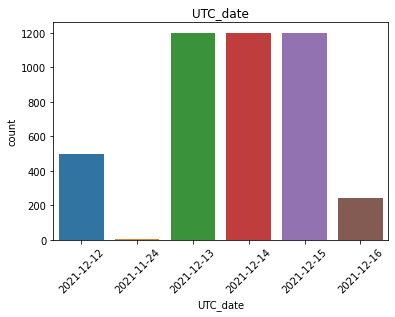

/home/jgreen0294/miniconda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


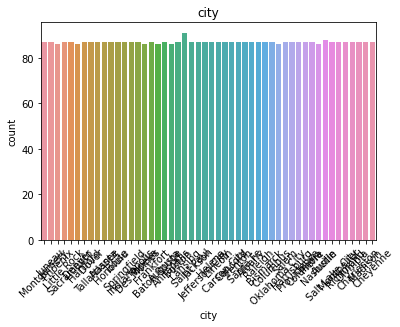

/home/jgreen0294/miniconda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


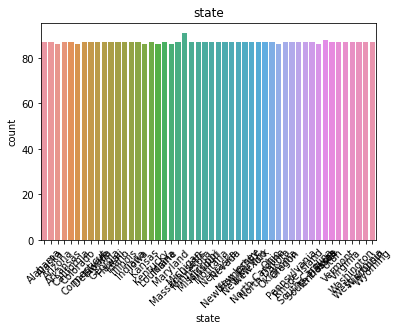

/home/jgreen0294/miniconda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


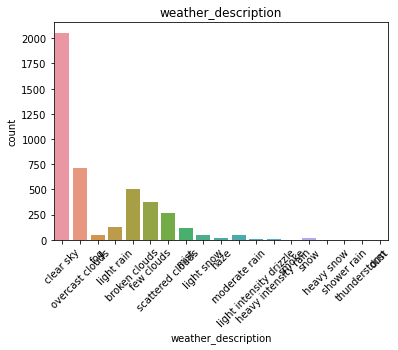

/home/jgreen0294/miniconda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


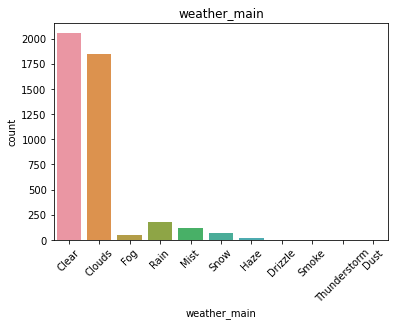

In [20]:

for col in ['UTC_date','city','state','weather_description','weather_main']:
    sns.countplot(final_data[col])
    plt.title(col)
    plt.xticks(rotation=45)
    plt.show()

UTC_date
2021-12-12    43.022000
2021-12-13    41.527500
2021-12-14    44.244167
2021-12-15    37.082083
2021-12-16    44.880000
Name: temp, dtype: float64


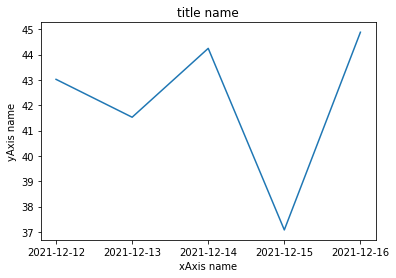

In [46]:
final_data_cp = final_data.copy()
final_data_cp = final_data_cp[final_data_cp['state']=='Rhode Island']
final_data_cp = final_data_cp[['UTC_date','temp']].reset_index(drop=True)
final_data_cp = final_data_cp.groupby('UTC_date')['temp'].mean()
print(final_data_cp)
plt.plot(final_data_cp)
plt.title('title name')
plt.xlabel('xAxis name')
plt.ylabel('yAxis name')
plt.show()


UTC_date
2021-12-12    63.435000
2021-12-13    58.727917
2021-12-14    63.203333
2021-12-15    54.246250
2021-12-16    51.075000
Name: temp, dtype: float64


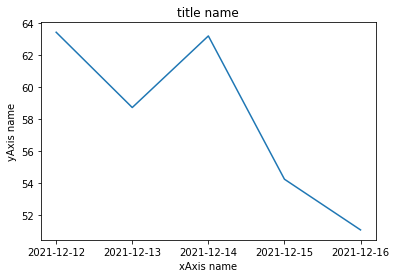

In [48]:
final_data_cp = final_data.copy()
final_data_cp = final_data_cp[final_data_cp['state']=='Arizona']
final_data_cp = final_data_cp[['UTC_date','temp']].reset_index(drop=True)
final_data_cp = final_data_cp.groupby('UTC_date')['temp'].mean()
print(final_data_cp)
plt.plot(final_data_cp)
plt.title('title name')
plt.xlabel('xAxis name')
plt.ylabel('yAxis name')
plt.show()

In [51]:
# regions and population

states = {'Alaska':['AK','O',733391],'Alabama':['AL', 'S',5024279],'Arkansas':['AR','S',3011524], 'Arizona':['AZ','W',7151502],'California':['CA','W',39538223], 'Colorado':['CO','W',5773714], 'Connecticut':['CT','N',3605944],'Delaware':['DE','N',989948],'Florida':['FL','S',21538187],'Georgia':['GA','S',10711908],'Hawaii':['HI','O',1455271],'Iowa':['IA','M',3190369],'Idaho':['ID','W',1839106],'Illinois':['IL','M',12812508],'Indiana':['IN','M',6785528],'Kansas':['KS', 'M',2937880],'Kentucky':['KY', 'S',4505836], 'Louisiana':['LA','S',4657757],'Massachusetts':['MA','N',7029917],'Maryland':['MD','N',6177224],'Maine':['ME','N',1362359],'Michigan':['MI','W',10077331],'Minnesota':['MN','M',5706494], 'Montana':['MO','M',6154913], 'Mississippi':['MS','S',2961279],'Montana':['MT','W',1084225],'North Carolina':['NC','S',10439388], 'North Dakota':['ND','M',779094],'Nebraska':['NE','W',1961504],'New Hampshire':['NH','N',1377529],'New Jersey':['NJ','N',9288994], 'New Mexico':['NM','W',2117522], 'Nevada':['NV','W',3104614],'New York':['NY','N',20201249],'Ohio':['OH','M',11799448],'Oklahoma':['OK','S',3959353], 'Oregon':['OR','W',4237256], 'Pennsylvania':['PA', 'N',13002700],'Rhode Island':['RI','N',1097379],'South Carolina':['SC','S',5118425], 'South Dakota':['SD','M',886667],'Tennessee':['TN','S',6910840], 'Texas':['TX','S',29145505], 'Utah':['UT','W',3271616], 'Virginia':['VA','S',8631393], 'Vermont':['VT','N',643077], 'Washington':['WA','W',7705281],'Wisconsin':['WI','M',5893718],'West Virginia':['WV','S',1793716], 'Wyoming':['WY','W',576851]}
state_abrev = {}
state_region = {}
state_pop = {}
for k, v in states.items():
    state_abrev[k] = v[0]
    state_region[k] = v[1]
    state_pop[k] = v[2]

In [55]:
region_df = final_data.copy()
region_df['region'] = region_df['state'].map(state_region)
region_df['abrev'] = region_df['state'].map(state_abrev)
region_df['pop'] = region_df['state'].map(state_pop)
region_df["region"].replace({"O": "Other", "W": "West", "N": "North", "S":"South", "M":"Midwest"}, inplace=True)
region_df = region_df.fillna(0)

region_df.head()


,UTC_date,UTC_time,city,state,local_date_airqual,local_time_airqual,local_date_weather,local_time_weather,full_time,time zone,...,humidity_weather,visibility,wind_speed,wind_deg,wind_gust,sunrise,sunset,region,abrev,pop
0,2021-12-12,14:00,Montgomery,Alabama,2021-12-12,08:00,2021-12-12,08:00,2021-12-12 08:00:00,-06:00,...,79.0,10000.0,0.45,136.0,0.89,06:37:31,16:40:51,South,AL,5024279.0
1,2021-12-12,14:00,Juneau,Alaska,2021-12-12,05:00,2021-12-12,05:00,2021-12-12 05:00:00,-09:00,...,78.0,10000.0,3.13,102.0,5.81,08:37:18,15:06:08,Other,AK,733391.0
2,2021-12-12,14:00,Phoenix,Arizona,2021-12-12,07:00,2021-12-12,07:00,2021-12-12 07:00:00,-07:00,...,45.0,10000.0,1.54,80.0,0.00,07:23:19,17:21:18,West,AZ,7151502.0
3,2021-12-12,14:00,Little Rock,Arkansas,2021-12-12,08:00,2021-12-12,08:00,2021-12-12 08:00:00,-06:00,...,93.0,10000.0,0.00,0.0,0.00,07:07:26,16:58:52,South,AR,3011524.0
4,2021-12-12,14:00,Sacramento,California,2021-12-12,06:00,2021-12-12,06:00,2021-12-12 06:00:00,-08:00,...,83.0,10000.0,0.45,144.0,2.24,07:14:44,16:45:16,West,CA,39538223.0


/home/jgreen0294/miniconda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


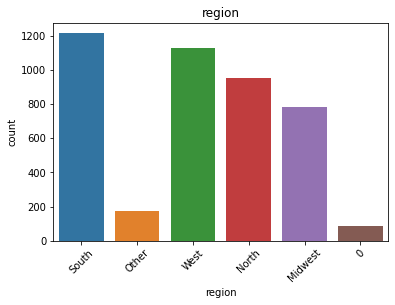

In [57]:

for col in ['region']:
    sns.countplot(region_df[col])
    plt.title(col)
    plt.xticks(rotation=45)
    plt.show()
    

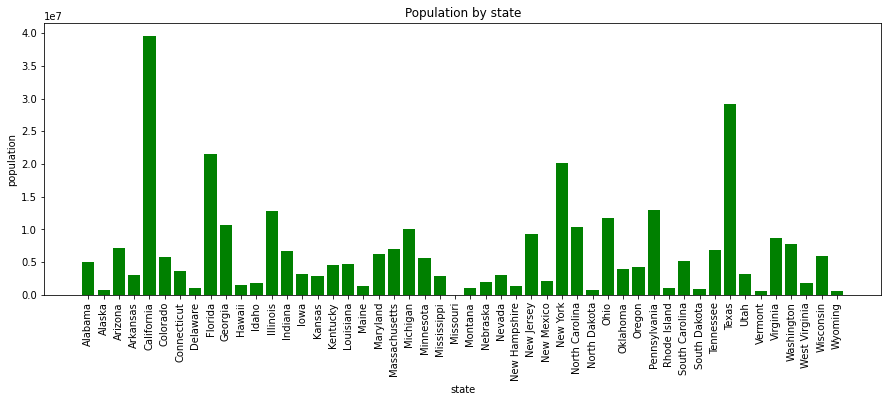

In [67]:
plt.figure(figsize=(15, 5))
plt.bar(region_df['state'], region_df['pop'], color='green')
plt.xlabel("state")
plt.xticks(rotation=90)
plt.ylabel("population")
plt.title("Population by state")

plt.show()

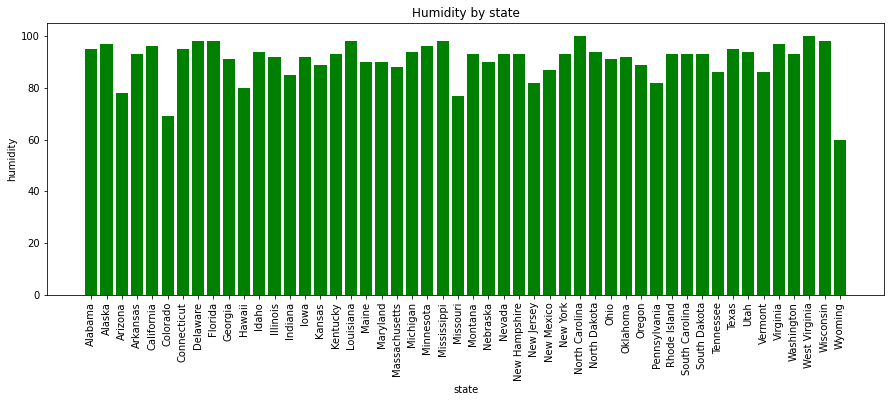

In [71]:
plt.figure(figsize=(15, 5))
plt.bar(region_df['state'], region_df['humidity_weather'], color='green')
plt.xlabel("state")
plt.xticks(rotation=90)
plt.ylabel("humidity")
plt.title("Humidity by state")

plt.show()

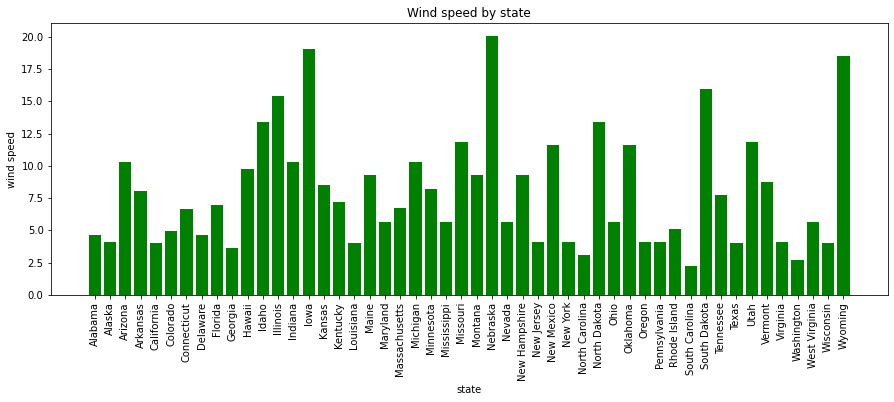

In [70]:
plt.figure(figsize=(15, 5))
plt.bar(region_df['state'], region_df['wind_speed'], color='green')
plt.xlabel("state")
plt.xticks(rotation=90)
plt.ylabel("wind speed")
plt.title("Wind speed by state")

plt.show()

In [56]:
aqi_hist = pd.read_csv('https://storage.googleapis.com/project-1050-data/2021_AQI_hist.csv')

aqi_hist_regions = aqi_hist.copy()
aqi_hist_regions['region'] = aqi_hist_regions['state'].map(state_region)
aqi_hist_regions['abrev'] = aqi_hist_regions['state'].map(state_abrev)
aqi_hist_regions['pop'] = aqi_hist_regions['state'].map(state_pop)
aqi_hist_regions["region"].replace({"O": "Other", "W": "West", "N": "North", "S":"South", "M":"Midwest"}, inplace=True)
aqi_hist_regions = aqi_hist_regions[['state', 'city','date','region','pop',' pm25', ' o3', ' pm10', ' no2',' so2', ' co']]
aqi_hist_regions = aqi_hist_regions.fillna(0)

aqi_hist_regions.head()


   Unnamed: 0       city         state        date   pm25    o3   pm10   no2  \
0      109421    Olympia    Washington  2021-01-01   13.0  19.0    NaN   NaN   
1       93658     Pierre  South Dakota  2021-01-01    5.0   NaN    NaN   NaN   
2       22928    Atlanta       Georgia  2021-01-01   51.0   NaN    NaN   NaN   
3       76378   Bismarck  North Dakota  2021-01-01   21.0  13.0    8.0   7.0   
4       48664  Saint Pau     Minnesota  2021-01-01   42.0   NaN    NaN   NaN   

    so2   co  
0   NaN  NaN  
1   NaN  NaN  
2   NaN  NaN  
3   7.0  1.0  
4   NaN  NaN  


,state,city,date,region,pop,pm25,o3,pm10,no2,so2,co
0,Washington,Olympia,2021-01-01,West,7705281.0,13.0,19.0,0.0,0.0,0.0,0.0
1,South Dakota,Pierre,2021-01-01,Midwest,886667.0,5.0,0.0,0.0,0.0,0.0,0.0
2,Georgia,Atlanta,2021-01-01,South,10711908.0,51.0,0.0,0.0,0.0,0.0,0.0
3,North Dakota,Bismarck,2021-01-01,Midwest,779094.0,21.0,13.0,8.0,7.0,7.0,1.0
4,Minnesota,Saint Pau,2021-01-01,Midwest,5706494.0,42.0,0.0,0.0,0.0,0.0,0.0
